# Data Pipeline

ah shit, 
here we go again
{insert cj meme here}

In [12]:
from _Setup import *

## TODO : Remove Columns w/ > 90% initial missing values

In [13]:
train_data = pd.read_pickle(rawTrainFilePickle)

test_data = pd.read_pickle(rawTestFilePickle)

submission_data = pd.read_csv(rawSubmissionFile)

# Train data preparation

In [14]:
# backward fill function
def backward_fill_by_patient(df, patient_id_col='patient'):
    # Create a copy of the original DataFrame
    df_imputed = df.copy()

    df_imputed.loc[:, df_imputed.columns != patient_id_col] = (
        df_imputed.groupby(patient_id_col)
        .bfill()
    )

    # If there are patients with no entries for a column, those columns will remain unchanged
    return df_imputed

In [15]:
def forward_fill_by_patient(df, patient_id_col='patient'):
    # Create a copy of the original DataFrame
    df_imputed = df.copy()

    df_imputed.loc[:, df_imputed.columns != patient_id_col] = (
        df_imputed.groupby(patient_id_col)
        .ffill()
    )
    
    # If there are patients with no entries for a column, those columns will remain unchanged
    return df_imputed

## TODO : Remove Columns w/ > 90% initial missing values

In [ ]:
# Identify columns with more than 90% missing values

missing_percentage = train_data.isnull().mean() * 100

cols_to_drop = missing_percentage[missing_percentage > 90].index

# Drop the identified columns

train_truncated = train_data.drop(columns=cols_to_drop)

In [16]:
#forward imputation
train_forward = forward_fill_by_patient(train_truncated)
train_forward.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,NaN,...,14.2,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,NaN,...,14.2,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,NaN,...,14.2,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,NaN,...,14.2,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


In [17]:
#backward imputation
pre_imputed_train = backward_fill_by_patient(train_forward)
pre_imputed_train.head()  

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,78.0,99.5,35.25,108.5,84.5,69.0,12.0,NaN,...,14.2,NaN,162.0,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,NaN,...,14.2,NaN,162.0,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,NaN,...,14.2,NaN,162.0,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,NaN,...,14.2,NaN,162.0,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,NaN,...,14.2,NaN,162.0,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


# TODO : MissForest imputation

In [18]:
# TODO : random sample of dataset before imputing data to save hours

imputer = MissForest(max_iter = 3)
imputed_data = imputer.fit_transform(pre_imputed_train)

 67%|██████▋   | 2/3 [13:16<06:40, 400.48s/it]c:\App\Anaconda3\envs\CaseComp\Lib\site-packages\missforest\missforest.py:348: UserWarning: NRMSE increased.
  warnings.warn("NRMSE increased.")
c:\App\Anaconda3\envs\CaseComp\Lib\site-packages\missforest\missforest.py:538: UserWarning: Stopping criterion triggered. Before last imputation matrix will be returned.
  warnings.warn("Stopping criterion triggered. Before last "
 67%|██████▋   | 2/3 [20:15<10:07, 607.88s/it]


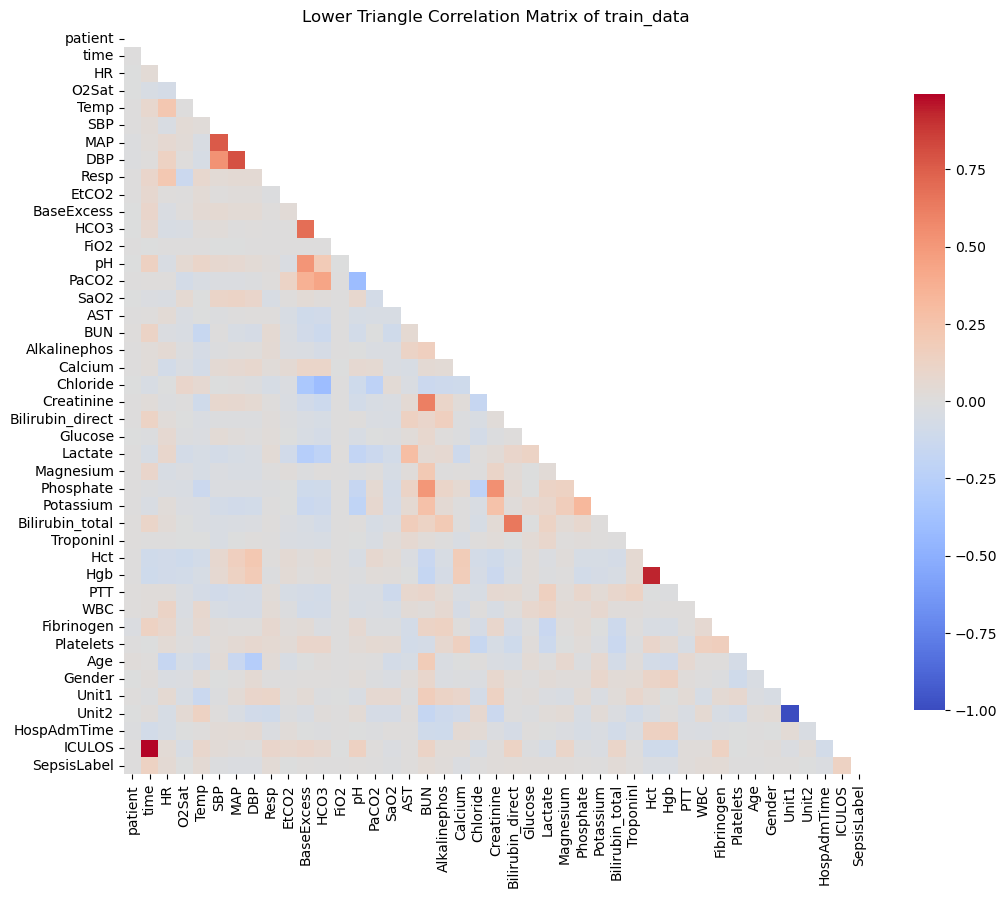

In [43]:
correlation_matrix = imputed_data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of train_data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

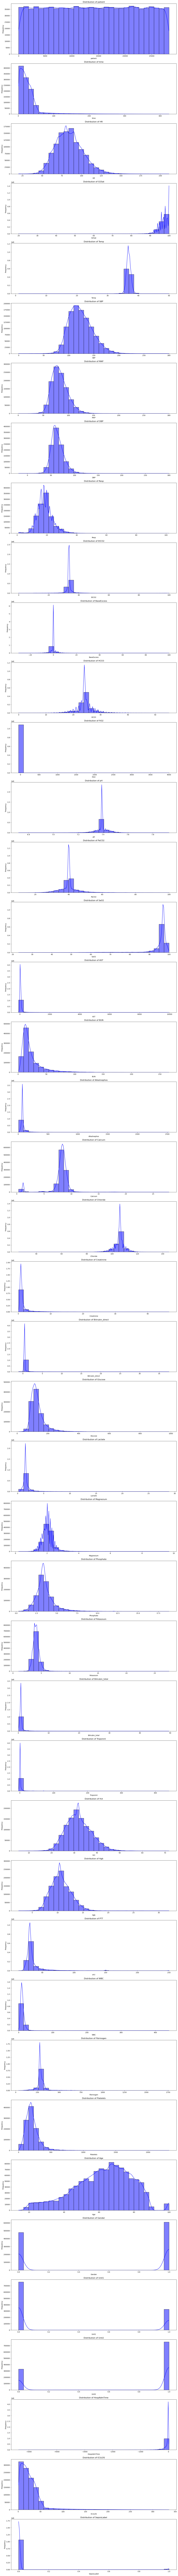

In [42]:
def plot_all_variable_distributions(df):
    """
    Plots the distribution of all numerical variables in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    """
    
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    
    num_vars = len(num_cols)
    plt.figure(figsize=(15, 5 * num_vars))
    
    for i, col in enumerate(num_cols):
        plt.subplot(num_vars, 1, i + 1)  
        sns.histplot(df[col], kde=True, bins=30, color='blue')  
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        
    plt.tight_layout()  
    plt.show()


plot_all_variable_distributions(imputed_data)

In [ ]:
imputed_data.to_csv(missForestTrainFile)